In [1]:
using LinearAlgebra, Test, SparseArrays, Plots, Parameters, OffsetArrays, DifferentialEquations, IterativeSolvers, LinearMaps
using DiffEqOperators
using Plots, BenchmarkTools
using Perla1

In [2]:
gr(fmt = :png);

In [3]:
# parameters for transition (change two to three/four if you want)
params = params_transition_default_two_cohorts(cohorts = (4, 4));

In [4]:
T = 100.0;
f_0 = [1.0; fill(0.0, set_size(params)-1)];

# Solve information dynamics

## Setup

In [5]:
# define the corresponding operator
transition_operator! = get_transition_operator(transition_operator_base!, params);

## Solve

In [6]:
# solve the corresponding ODE
sol_awareness = solve_transition_dynamics(transition_operator!, params, f_0, T);

## Plot

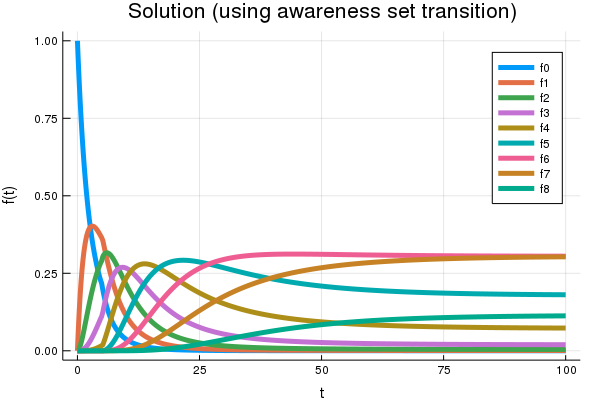

In [7]:
N = params.cohorts[1] # assume that N_t is invariant across all t
K = length(params.cohorts) # number of cohorts

# convert to the counting solution
indices = CartesianIndices(reshape(1:set_size(params), Tuple(fill(0:N, K))))
counts = (x -> sum(indices[x])).(1:set_size(params)) # index to count size
fn_awareness_matrix_free = (n -> (a -> sum(sol_awareness(a)[counts .== n]))).(0:sum(params.cohorts))

# plot
plot(0:0.01:T, fn_awareness_matrix_free,linewidth=5,
    title="Solution (using awareness set transition)",
     xaxis="t",yaxis="f(t)",label=string.("f",0:sum(params.cohorts)))

## Find stationary distribution

  0.898977 seconds (3.14 M allocations: 149.228 MiB, 8.05% gc time)


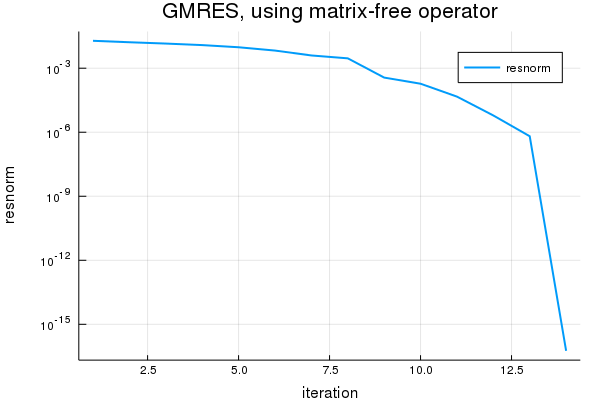

In [8]:
map_matfree! = LinearMap((y,x) -> transition_operator_base!(y, x, params, T), length(f_0); ismutating=true)
stationary, history = @time gmres!(fill(1/length(f_0), length(f_0)), map_matfree!, similar(f_0), log = true)
stationary /= sum(stationary) # normalize
plot(history, yscale = :log10,linewidth=2,
    title="GMRES, using matrix-free operator",
    xaxis="iteration",yaxis="resnorm")

In [9]:
@test stationary ≈ sol_awareness(T) atol=1e-2 # T should be large enough

Test Passed

# Solve price equilibrium dynamics

## Setup

In [10]:
ts = range(0, stop = (params.ts_cohort[end] *2), length = 50) # range of a to sample f from

0.0:0.20408163265306123:10.0

In [11]:
params_demand = params_demand_default_asymmetric(cohorts = params.cohorts, 
    N_ks = [Int64(params.cohorts[1] / 2), Int64(params.cohorts[1] / 2)]) 
profit = get_profit(demand_asymmetric) # change demand function if you want

#35 (generic function with 1 method)

## Solve

In [12]:
fs = sol_awareness.(ts) # sampled awareness distributions
ps = (f -> compute_price_equilibrium(f, params_demand, profit).p).(fs) # equilibrium prices at fs
ps_stationary = compute_price_equilibrium(stationary, params_demand, profit).p # equilibrium price at stataionry f

2×2 Array{Float64,2}:
 1.15157  1.15157
 1.18367  1.18367

In [13]:
get_ps = (k, b) -> (p -> p[k, b]).(ps); # returns equilibrium prices for k-type bth cohort firms

## Plot

In [14]:
# helper function for plots
function generate_plot(b, ts, ps, ps_stationary)
   plot(ts, get_ps.(1:2, b),linewidth=5,
    title="Price equilibrium dynamics",
     xaxis="t",yaxis="p_{k,b}(t)",label=string.("p_{",1:length(params.cohorts),",", b, "}"))
    plot!(ts, (p -> fill(p, length(ts))).(ps_stationary[:,b]),
        label=[string.("p_{",1:length(params.cohorts),",", b, "}");
               string.("p_{",1:length(params.cohorts),",", b, "} (stationary)")],
        linewidth=2, linestyle = :dash) 
end;

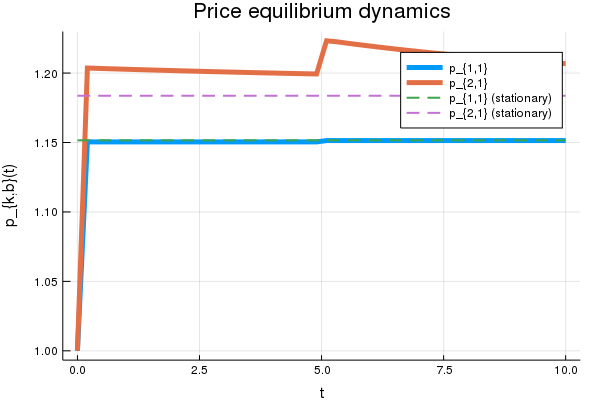

In [15]:
generate_plot(1, ts, get_ps.(1:2, 1), ps_stationary)

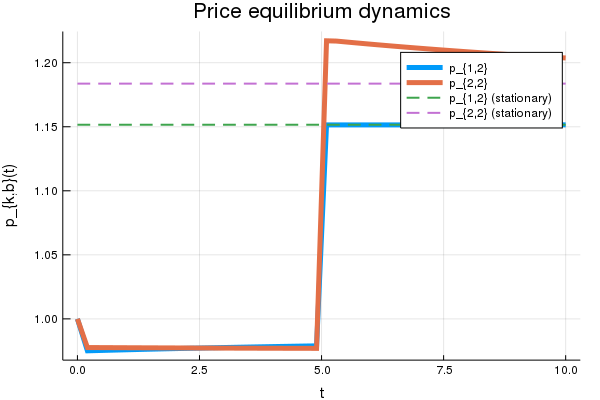

In [16]:
generate_plot(2, ts, get_ps.(1:2, 2), ps_stationary)

In [17]:
# # enable the following line if there is a 3rd cohort
# generate_plot(3, ts, get_ps.(1:2, 3), ps_stationary)